In [ ]:
!pip install torchsummary 

In [ ]:
device = "cuda"

In [ ]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split
import torchvision.models as models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/Shareddrives/442/original.zip

Archive:  /content/drive/Shareddrives/442/original.zip
   creating: original/
  inflating: __MACOSX/._original     
  inflating: original/20151211_123531.jpg  
  inflating: __MACOSX/original/._20151211_123531.jpg  
  inflating: original/20151203_130958.jpg  
  inflating: __MACOSX/original/._20151203_130958.jpg  
  inflating: original/20151211_134059.jpg  
  inflating: __MACOSX/original/._20151211_134059.jpg  
  inflating: original/20151211_133050.jpg  
  inflating: __MACOSX/original/._20151211_133050.jpg  
  inflating: original/20151211_123243.jpg  
  inflating: __MACOSX/original/._20151211_123243.jpg  
  inflating: original/20151221_120249.jpg  
  inflating: __MACOSX/original/._20151221_120249.jpg  
  inflating: original/20151204_124547.jpg  
  inflating: __MACOSX/original/._20151204_124547.jpg  
  inflating: original/20151204_130532.jpg  
  inflating: __MACOSX/original/._20151204_130532.jpg  
  inflating: original/20151211_125829.jpg  
  inflating: __MACOSX/original/._20151211_125829

In [ ]:
!unzip /content/drive/Shareddrives/442/annotationsrcnnUP.zip

Archive:  /content/drive/Shareddrives/442/annotationsrcnnUP.zip
   creating: annotationsrcnn/
  inflating: annotationsrcnn/20151204_133346.csv  
  inflating: annotationsrcnn/20151204_121024.csv  
  inflating: annotationsrcnn/20151221_134800.csv  
  inflating: annotationsrcnn/20151211_130817.csv  
  inflating: annotationsrcnn/20151127_134546.csv  
  inflating: annotationsrcnn/20151204_124821.csv  
  inflating: annotationsrcnn/20151211_140116.csv  
  inflating: annotationsrcnn/20151203_125225.csv  
  inflating: annotationsrcnn/20151211_125942.csv  
  inflating: annotationsrcnn/20151203_124649.csv  
  inflating: annotationsrcnn/20151221_123824.csv  
  inflating: annotationsrcnn/20151211_115842.csv  
  inflating: annotationsrcnn/20151221_131207.csv  
  inflating: annotationsrcnn/20151211_134640.csv  
  inflating: annotationsrcnn/20151221_132040.csv  
  inflating: annotationsrcnn/20151221_134431.csv  
  inflating: annotationsrcnn/20151204_133030.csv  
  inflating: annotationsrcnn/20151204_1

In [ ]:
path = "original"  #for the actual images
annot = "annotationsrcnn" #for the annotations


## Dataset

20151204_133158.jpg
616 447 742 311
348 370 561 179
671 249 748 171
603 200 687 123
120 373 297 237
108 478 319 294


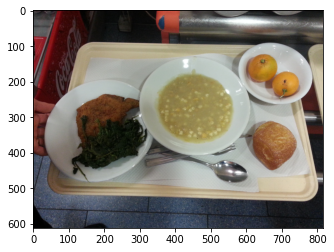

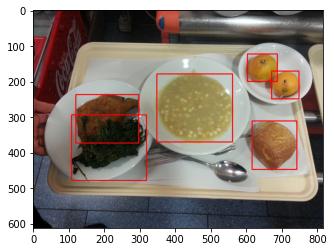

In [ ]:
from torch._C import dtype
for e, i in enumerate(os.listdir(annot)):
  if e < 10:
    filename = i.split(".")[0] + ".jpg"
    print(filename)
    img = cv2.imread(os.path.join(path,filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    df = pd.read_csv(os.path.join(annot, i))
    #img = cv2.rotate(img, cv2.ROTATE_180)
    w = int(img.shape[0]*.25)
    h = int(img.shape[1]*.25)
    img = cv2.resize(img, (h,w), interpolation = cv2.INTER_AREA)
    plt.imshow(img)
    for row in df.iterrows():
      
      x1 = int(row[1][7]*.25)
      y1 = int(row[1][8]*.25)
      x2 = int(row[1][3]*.25)
      y2 = int(row[1][4]*.25)
      print(x1, y1, x2, y2)
      cv2.rectangle(img, (x1, y1), (x2,y2), (255,0,0), 2)
    plt.figure()
    plt.imshow(img)
    break

In [ ]:
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()


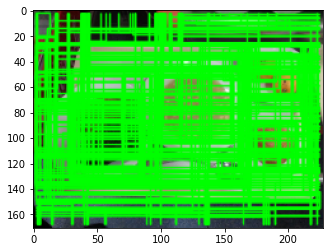

In [ ]:
im = cv2.imread(os.path.join(path, "20151204_133158.jpg"))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#im = cv2.rotate(im, cv2.ROTATE_180)
w = int(im.shape[0]*.07)
h = int(im.shape[1]*.07)
dim = (h,w)
im = cv2.resize(im, (h,w), interpolation = cv2.INTER_AREA)
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in enumerate(rects):
  x, y, w, h = rect
  cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imOut)

In [ ]:
train_images = []
train_labels = []

In [ ]:
def get_iou(box1, box2):
  assert box1['x1'] <= box1['x2']
  assert box1['y1'] >= box1['y2']
  assert box2['x1'] <= box2['x2']
  assert box2['y1'] >= box2['y2']

  xleft = max(box1['x1'], box2['x1'])
  ytop = min(box1['y1'], box2['y1']) 
  xright = min(box1['x2'], box2['x2'])
  ybottom = max(box1['y2'], box2['y2'])

  if xright < xleft or ybottom > ytop:
    return 0.0
  intersection_area = (xright - xleft) * (ytop - ybottom)
  print(intersection_area)
  box1area = (box1['x2'] - box1['x1']) * (box1['y1'] - box1['y2'])
  box2area = (box2['x2'] - box2['x1']) * (box2['y1'] - box2['y2'])
  print(box1area, box2area)

  iou = intersection_area / float(box1area + box2area - intersection_area)
  assert iou >= 0.0
  assert iou <= 1.0
  return iou
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
for e,i in enumerate(os.listdir(annot)):
        if e > 550:
          break
        filename = i.split(".")[0]+".jpg"
        print(e,filename)
        image = cv2.imread(os.path.join(path,filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.rotate(image, cv2.ROTATE_180)
        w = int(image.shape[0]*.1)
        h = int(image.shape[1]*.1)
        dim = (h,w)
        image = cv2.resize(image, (h,w), interpolation = cv2.INTER_AREA)
        df = pd.read_csv(os.path.join(annot,i))
        gtvalues=[]
        for row in df.iterrows():
            x1 = int(row[1][7]*.1)
            y1 = int(row[1][8]*.1)
            x2 = int(row[1][3]*.1)
            y2 = int(row[1][4]*.1)
            gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = image.copy()
        counter = 0
        falsecounter = 0
        flag = 0
        fflag = 0
        bflag = 0
        for e,result in enumerate(ssresults):
            if e < 2000 and flag == 0:
                for gtval in gtvalues:
                    x,y,w,h = result
                    iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y+h,"y2":y})
                    if counter < 30:
                        if iou > 0.70:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(1)
                            counter += 1
                    else :
                        fflag =1
                    if falsecounter <30:
                        if iou < 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            falsecounter += 1
                    else :
                        bflag = 1
                if fflag == 1 and bflag == 1:
                    print("inside")
                    flag = 1
                    break

Streaming output truncated to the last 5000 lines.
7128 1496
216
2091 1496
5394
7128 16728
702
7128 936
264
7128 1364
93
2091 1364
2880
6216 4161
851
2436 4161
1476
2091 4161
182
2436 624
280
7128 620
52
7128 4920
464
2436 4920
30
2436 544
58
2436 10998
182
7128 4459
348
2436 3360
493
812 8320
418
1064 8320
336
1064 7876
437
812 9040
6237
7128 9040
882
6216 1372
99
812 252
300
7128 300
1620
7128 17250
5846
6216 17250
2378
2436 17250
2091
2091 17250
377
812 3953
418
1064 3953
1292
7128 3953
255
2436 2343
116
812 17604
812
812 46458
1064
1064 46458
7128
7128 46458
6216
6216 46458
2436
2436 46458
2091
2091 46458
1625
7128 3510
58
2436 3993
528
2436 552
78
2091 552
377
812 10296
589
1064 10296
4819
7128 10296
232
812 2262
182
1064 2262
722
7128 2262
42
2436 945
52
7128 5160
464
2436 5160
260
2436 891
87
812 6784
812
812 61614
1064
1064 61614
7128
7128 61614
6216
6216 61614
2436
2436 61614
2091
2091 61614
567
7128 567
434
2436 1023
70
2091 1023
120
7128 405
290
812 9216
464
1064 9216
4440
7

KeyboardInterrupt: ignored

In [ ]:

Xnew = np.array(train_images)
ynew = np.array(train_labels)
# np.save('train_imgs.npy', train_images)
# np.save('train_labs.npy', train_labels)
del(train_images)
del(train_labels)
Xnew.shape

(18477, 224, 224, 3)

## Pre-trained CNN with Frozen Layers

In [ ]:
def freeze_layers(net, num_layers):
  idx = 0
  for name, param in net.named_parameters():
    if idx >= num_layers*2:
      break
    param.requires_grad_(False)
    idx += 1

net = models.resnet18(pretrained=True)
net = nn.Sequential(
    net,
    nn.Linear(1000, 2),    
    nn.Softmax(dim=1)
)
summary(net, (3, 224, 224))
num_layers = 30
freeze_layers(net, num_layers)

model_final = net


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Model Parameters

In [ ]:
optimizer = optim.Adam(model_final.parameters(), lr=0.0069)
criterion = nn.CrossEntropyLoss()


## Process Data

In [ ]:
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [ ]:
class Label_Binarizer(preprocessing.LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
lab = Label_Binarizer()
Y = lab.fit_transform(ynew)

In [ ]:
#Xnew = np.load('train_imgs.npy')
X_train, X_test , y_train, y_test = train_test_split(Xnew[:10000],Y[:10000],test_size=0.10)
# np.save('X_train.npy', X_train)
# np.save('X_test.npy', X_test)
# np.save('y_train.npy', y_train)
# np.save('y_test.npy', y_test)


In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9000, 224, 224, 3) (1000, 224, 224, 3) (9000, 2) (1000, 2)


In [ ]:
import torch.utils.data
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

In [ ]:
class fData(Dataset):
  def __init__(self, X, y):
    super(Dataset, self).__init__()
    assert X.shape[0] == y.shape[0]
    self.X = X
    self.y = y
  
  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    img = torch.FloatTensor(self.X[idx]).permute(2, 0, 1)
    tar = torch.FloatTensor(self.y[idx])
    return img, tar



In [ ]:
trd = fData(X_train[:8992], y_train[:8992])
train_data = DataLoader(trd, batch_size=32, shuffle=True) #idk 
# np.save('X_train.npy', X_train)
# np.save('X_test.npy', X_test)
#del ynew
del X_train
del y_train

In [ ]:
del Xnew

In [ ]:
tvd = fData(X_test[:992], y_test[:992])
testVal_data = DataLoader(tvd, batch_size=32, shuffle=True)
del X_test, y_test

In [ ]:
import time
def train(trainloader, net, criterion, optimizer, device, epoch):
    '''
    Function for training.
    '''
    start = time.time()
    running_loss = 0.0
    cnt = 0
    net = net.train()
    
    for images, labels in tqdm(trainloader):
        #images = images.to(device)
        #labels = labels.to(device)
        #print(images.shape)
        images.resize_(32, 3, 224, 224)
        optimizer.zero_grad()
        output = net(images)
        #print(output.shape)
        loss = criterion(output, labels)
        #print(loss)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        cnt += 1
    end = time.time()
    running_loss /= cnt
    print('\n [epoch %d] loss: %.3f elapsed time %.3f' %
        (epoch, running_loss, end-start))
    return running_loss

def test(testloader, net, criterion, device):
    '''
    Function for testing.
    '''
    losses = 0.
    cnt = 0
    
    with torch.no_grad():
        net = net.eval()
        for images, labels in tqdm(testloader):
            #images = images.to(device)
            #labels = labels.to(device)
            images.resize_(32, 3, 224, 224)
            output = net(images)
            loss = criterion(output, labels)
            losses += loss.item()
            cnt += 1
    print('\n',losses / cnt)
    return (losses/cnt)

def get_result(testloader, net, device, folder='output_train'):
    result = []
    cnt = 1
    os.makedirs(folder, exist_ok=True)
    with torch.no_grad():
        net = net.eval()
        cnt = 0
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            
            output = net(images)[0].cpu().numpy()
            c, h, w = output.shape
            y = np.argmax(output, 0).astype('uint8')
            gt = labels.cpu().data.numpy().squeeze(0).astype('uint8')
            plt.imsave('./{}/x{}.png'.format(folder, cnt),
                     images[0].cpu().data.numpy().astype(np.uint8).transpose(1,2,0))
            cnt += 1


In [ ]:
num_epoch = 5
if torch.cuda.is_available():
    train_data = train_data.to('cuda')
    net.to('cuda')
net.train()
print(device)
for epoch in range(num_epoch): #TODO: Change the number of epochs
    print('-----------------Epoch = %d-----------------' % (epoch+1))
    print('train loss: ')
    trn_loss = train(train_data, net, criterion, optimizer, device, epoch+1)
    print('train loss: ', trn_loss)
    print('Validation loss: ')
    val_loss = test(testVal_data, net, criterion, device)
    print('validation loss: ', val_loss)

net.eval()
test(testVal_data, net, criterion, device)


NameError: ignored

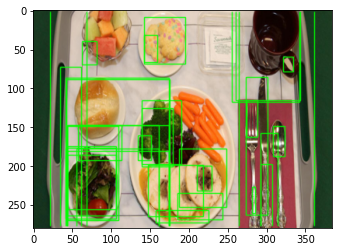

In [ ]:
test = cv2.imread("testimage.jpeg")
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
#im = cv2.rotate(im, cv2.ROTATE_180)
w = int(test.shape[0]*.35)
h = int(test.shape[1]*.25)
dim = (h,w)
test = cv2.resize(test, (h,w), interpolation = cv2.INTER_AREA)
ss.setBaseImage(test)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = test.copy()
for e,result in enumerate(ssresults):
  if e < 2000:
    x,y,w,h = result
    timage = imout[y:y+h,x:x+w]
    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
    img = np.expand_dims(resized, axis=3)
    img = torch.FloatTensor(img.T)
    #print(img.shape)
    
    out= net(img)
    if out[0][0] > 0.61:
      cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imout)